# Use Case 2: Data Pipeline for Customer Feedback Analysis

In [21]:
%pip install pyspark textblob

^C


In [22]:
print("24MAI0070 PRIYA RAI ")

24MAI0070 PRIYA RAI 


In [23]:
from pyspark.sql import SparkSession
import pandas as pd
from pyspark.sql.types import (
    StructType, StructField, StringType,
    IntegerType, TimestampType
)
from pyspark.sql.functions import col, to_timestamp, udf, count, avg
from pyspark.sql import functions as F
import datetime
import random
from textblob import TextBlob
import matplotlib.pyplot as plt
import seaborn as sns

Initialize the Spark Session

In [24]:
# Initialize Spark session
spark = SparkSession.builder \
    .appName("CustomerFeedbackAnalysis") \
    .config("spark.driver.memory", "2g") \
    .getOrCreate()

# Define schema for feedback data
feedback_schema = StructType([
    StructField("Customer_ID", StringType(), False),
    StructField("Feedback_Channel", StringType(), False),
    StructField("Rating", IntegerType(), False),
    StructField("Comment", StringType(), True),
    StructField("Date", TimestampType(), False)
])

# 1. Data Ingestion:
* Using Apache Spark to ingest data in real time.

In [25]:
##Generate Sample Data in Spark


def generate_spark_data(num_records=1000):
    """Generate sample data in Spark"""
    channels = ["Email", "Social Media", "Survey"]
    comments = ["Great service!", "Need improvement", "Average experience", "Fantastic!", "Horrible service!", "Will recommend!"]

    data = []
    current_date = datetime.datetime.now()

    for _ in range(num_records):
        data.append((
            f"C{random.randint(10000, 99999)}",
            random.choice(channels),
            random.randint(1, 5),
            random.choice(comments),
            (current_date - datetime.timedelta(days=random.randint(0, 30)))
        ))

    # Create Spark DataFrame
    return spark.createDataFrame(data, ["Customer_ID", "Feedback_Channel", "Rating", "Comment", "Date"])

# Generate the Spark DataFrame
spark_df = generate_spark_data(10000)
spark_df.show(5)


+-----------+----------------+------+------------------+--------------------+
|Customer_ID|Feedback_Channel|Rating|           Comment|                Date|
+-----------+----------------+------+------------------+--------------------+
|     C77212|    Social Media|     3|    Great service!|2024-10-29 09:49:...|
|     C77774|    Social Media|     2|Average experience|2024-11-04 09:49:...|
|     C22425|           Email|     5|    Great service!|2024-10-27 09:49:...|
|     C71327|    Social Media|     3|    Great service!|2024-10-08 09:49:...|
|     C28448|          Survey|     2|Average experience|2024-10-20 09:49:...|
+-----------+----------------+------+------------------+--------------------+
only showing top 5 rows



Convert Spark DataFrame to Pandas DataFrame

In [26]:
def spark_to_pandas(spark_df):
    """Convert Spark DataFrame to Pandas DataFrame"""
    try:
        pandas_df = spark_df.toPandas()
        print(f"Successfully converted {len(pandas_df)} records to pandas DataFrame")
        return pandas_df
    except Exception as e:
        print(f"Error converting to pandas: {e}")
        return None

# Convert Spark DataFrame to Pandas DataFrame
pandas_df = spark_to_pandas(spark_df.limit(1000))
print(pandas_df.head())

Successfully converted 1000 records to pandas DataFrame
  Customer_ID Feedback_Channel  Rating             Comment  \
0      C77212     Social Media       3      Great service!   
1      C77774     Social Media       2  Average experience   
2      C22425            Email       5      Great service!   
3      C71327     Social Media       3      Great service!   
4      C28448           Survey       2  Average experience   

                        Date  
0 2024-10-29 09:49:05.498079  
1 2024-11-04 09:49:05.498079  
2 2024-10-27 09:49:05.498079  
3 2024-10-08 09:49:05.498079  
4 2024-10-20 09:49:05.498079  


## **2.Data Cleaning**

In [27]:
def clean_data(df):
    """Clean the feedback comments"""
    # Remove unnecessary characters and handle missing values
    df['Comment'] = df['Comment'].str.replace(r'[^a-zA-Z0-9\s]', '', regex=True).str.strip()
    df['Comment'] = df['Comment'].fillna('No Comment')
    return df

# Clean the data
pandas_df = clean_data(pandas_df)
print(pandas_df.head())

  Customer_ID Feedback_Channel  Rating             Comment  \
0      C77212     Social Media       3       Great service   
1      C77774     Social Media       2  Average experience   
2      C22425            Email       5       Great service   
3      C71327     Social Media       3       Great service   
4      C28448           Survey       2  Average experience   

                        Date  
0 2024-10-29 09:49:05.498079  
1 2024-11-04 09:49:05.498079  
2 2024-10-27 09:49:05.498079  
3 2024-10-08 09:49:05.498079  
4 2024-10-20 09:49:05.498079  


## **3.Sentiment Analysis:**
* Perform sentiment analysis on the unstructured text data to classify feedback as positive, neutral, or negative.

In [28]:
def analyze_sentiment(comment):
    """Analyze sentiment of the comment"""
    analysis = TextBlob(comment)
    if analysis.sentiment.polarity > 0:
        return 'Positive'
    elif analysis.sentiment.polarity == 0:
        return 'Neutral'
    else:
        return 'Negative'

# Perform sentiment analysis
sentiment_udf = udf(analyze_sentiment, StringType())
spark_df = spark_df.withColumn("Sentiment", sentiment_udf(col("Comment")))


In [29]:
def perform_analysis(pandas_df):
    """Perform basic analysis on the pandas DataFrame"""
    if pandas_df is None:
        print("No data available for analysis")
        return None

    analysis = {
        'total_records': len(pandas_df),
        'channel_distribution': pandas_df['Feedback_Channel'].value_counts().to_dict(),
        'average_rating': pandas_df['Rating'].mean(),
        'rating_distribution': pandas_df['Rating'].value_counts().sort_index().to_dict()
    }

    return analysis

# Perform analysis on the processed Pandas DataFrame
analysis = perform_analysis(pandas_df)
if analysis:
    print("\nAnalysis Results:")
    for key, value in analysis.items():
        print(f"{key}: {value}")


Analysis Results:
total_records: 1000
channel_distribution: {'Social Media': 342, 'Email': 333, 'Survey': 325}
average_rating: 2.972
rating_distribution: {1: 197, 2: 219, 3: 193, 4: 197, 5: 194}


# **4. Trend Analysis:**

Analyze feedback trends over time.

Determine which feedback channels generate the most negative or positive comments.

Calculate average ratings per channel and identify areas for improvement.

In [30]:
# Trend analysis
def trend_analysis(spark_df):
    """Analyze trends over time and by channel"""
    # Convert date to date format
    spark_df = spark_df.withColumn("Date", to_timestamp(col("Date")))

    # Average ratings per channel
    avg_rating_per_channel = spark_df.groupBy("Feedback_Channel").agg(avg("Rating").alias("Average_Rating"))
    avg_rating_per_channel.show()

    # Count of sentiments by channel
    sentiment_distribution = spark_df.groupBy("Feedback_Channel", "Sentiment").agg(count("Sentiment").alias("Count"))
    sentiment_distribution.show()

    # Generate plots
    return avg_rating_per_channel, sentiment_distribution

avg_rating_per_channel, sentiment_distribution = trend_analysis(spark_df)

+----------------+------------------+
|Feedback_Channel|    Average_Rating|
+----------------+------------------+
|           Email|3.0283987915407855|
|    Social Media| 3.024217365623154|
|          Survey| 2.984866828087167|
+----------------+------------------+

+----------------+---------+-----+
|Feedback_Channel|Sentiment|Count|
+----------------+---------+-----+
|    Social Media| Negative| 1122|
|           Email|  Neutral| 1106|
|    Social Media|  Neutral| 1099|
|           Email| Positive| 1114|
|          Survey| Positive| 1110|
|    Social Media| Positive| 1165|
|          Survey| Negative| 1075|
|           Email| Negative| 1090|
|          Survey|  Neutral| 1119|
+----------------+---------+-----+



## 5.Data Visualization:
* Create visualizations to show sentiment distribution, feedback trends, and channel performance.

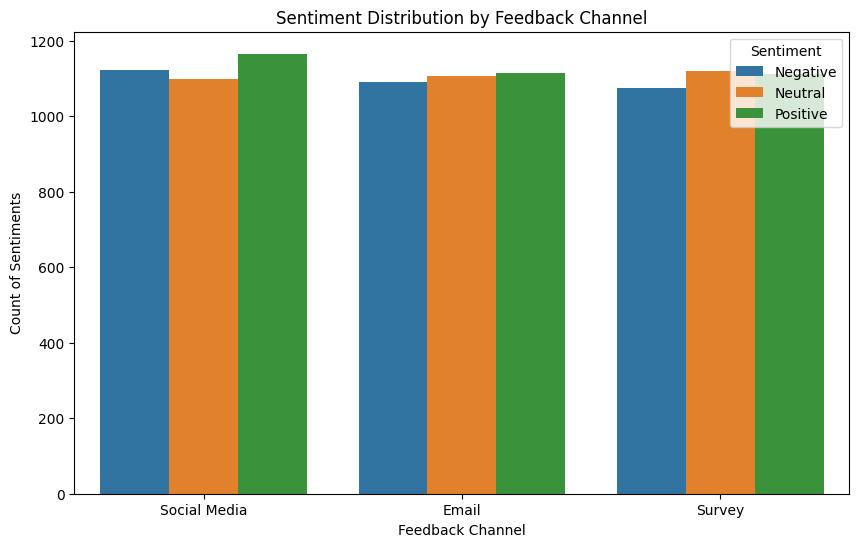

In [31]:
# Visualization Functions
def visualize_sentiment_distribution(sentiment_distribution):
    """Visualize sentiment distribution"""
    sentiment_pd = sentiment_distribution.toPandas()
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Feedback_Channel', y='Count', hue='Sentiment', data=sentiment_pd)
    plt.title('Sentiment Distribution by Feedback Channel')
    plt.ylabel('Count of Sentiments')
    plt.xlabel('Feedback Channel')
    plt.legend(title='Sentiment')
    plt.show()

visualize_sentiment_distribution(sentiment_distribution)


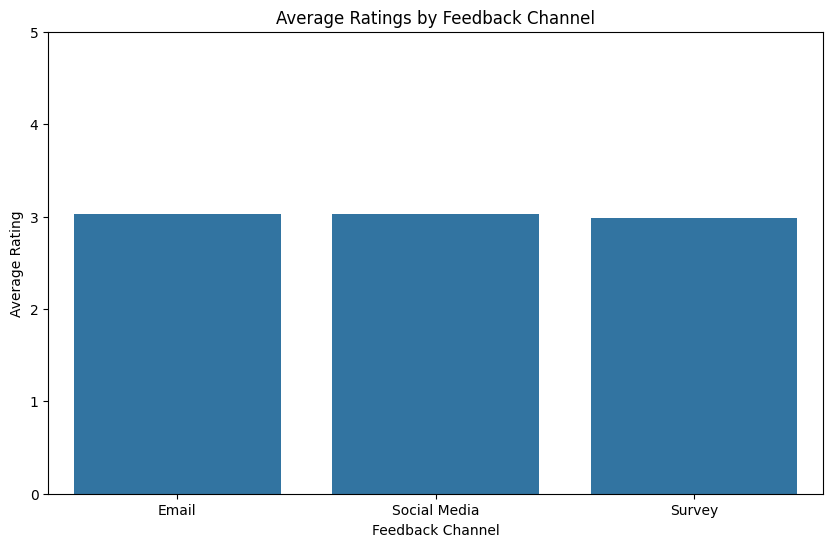

In [33]:
def visualize_average_ratings(avg_rating_per_channel):
    """Visualize average ratings by feedback channel"""
    avg_rating_pd = avg_rating_per_channel.toPandas()
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Feedback_Channel', y='Average_Rating', data=avg_rating_pd)
    plt.title('Average Ratings by Feedback Channel')
    plt.ylabel('Average Rating')
    plt.xlabel('Feedback Channel')
    plt.ylim(0, 5)  # Set y-axis limit
    plt.show()

visualize_average_ratings(avg_rating_per_channel)

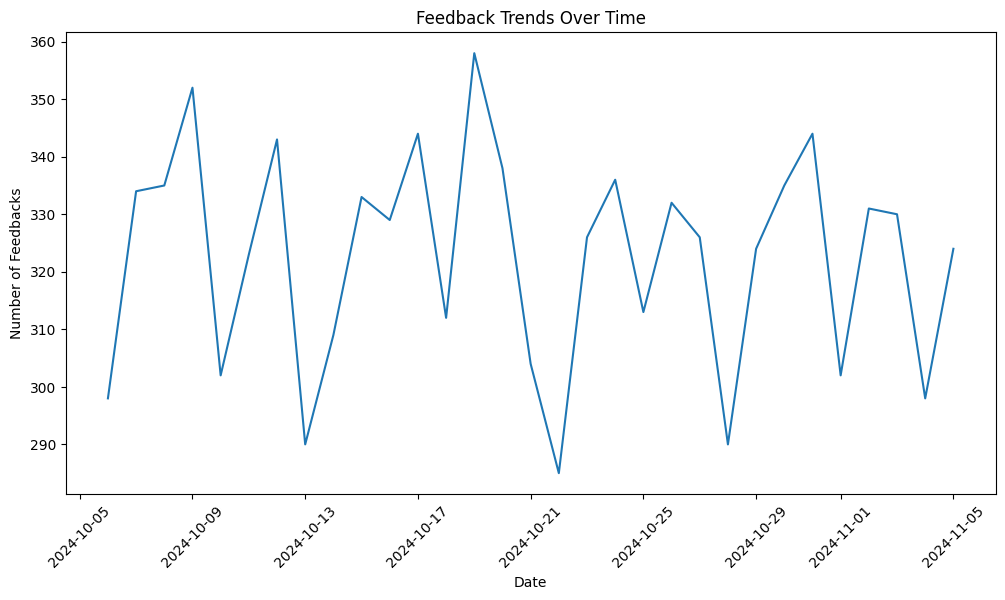

In [32]:
def visualize_trends_over_time(spark_df):
    """Visualize feedback trends over time"""
    trend_data = spark_df.groupBy(F.to_date(col("Date")).alias("Date")).agg(count("Customer_ID").alias("Feedback_Count"))
    trend_data_pd = trend_data.toPandas()

    plt.figure(figsize=(12, 6))
    sns.lineplot(data=trend_data_pd, x='Date', y='Feedback_Count')
    plt.title('Feedback Trends Over Time')
    plt.ylabel('Number of Feedbacks')
    plt.xlabel('Date')
    plt.xticks(rotation=45)
    plt.show()
visualize_trends_over_time(spark_df)


# cleanup

In [16]:
# Stop Spark session
spark.stop()